#  PaySim 데이터 기반 AARRR 리스크 분석 보고서

---

## **PART 1: 분석 목적 및 프레임워크 정의**

### **1.1 분석 목표 및 핵심 변수**

* **목표**: PaySim 거래 데이터에 **AARRR** 프레임워크를 적용하여, 사기 계정이 **고객 여정의 어느 단계**에서 시스템을 우회하는지 **정량적으로** 식별하는 것이 목표임.
* **핵심 결과**: 발견된 패턴을 기반으로 **위험 기반 정책(Risk-Based Policy)**을 수립하는 데 필요한 **핵심 탐지 변수**를 도출함.

### **1.2 AARRR 프레임워크 (리스크 관점 재해석)**

AARRR을 리스크 관리 관점으로 재해석하여, 각 단계가 사기 시도에 대한 **방어벽** 또는 **노출 지점**으로서의 역할을 분석함.

| 단계 | **핵심 지표** | 리스크 관점 (사기꾼의 행동 의도) |
| :--- | :--- | :--- |
| **Activation ($\text{A}$)** | `isActivation` | **신뢰 획득 단계**임. 사기꾼은 불필요한 절차를 **회피**하거나 **최소화**하려 함. |
| **Revenue ($\text{R}$)** | `amount` | **수익 탈취 단계**임. 사기꾼은 **최대 Monetary Value**를 한 번에 빼내려 함. |
| **Referral ($\text{R}$)** | `isReferral` | **계정 대량 생성 유틸리티**로 악용되는지 확인이 필요함. |

---

## **PART 2: PaySim 데이터 맞춤 리스크 가설**

RFM 분석에서 파악된 **고액($\text{M}$↑) 및 단발성($\text{F}$↓)** 패턴의 **원인**을 AARRR 여정에서 추적함.

### **2.1. Activation ($\text{A}$) 리스크 가설**

* **가설**: 사기 계정은 **활성화되지 않은 상태(`isActivation = 0`)**에서 **최초의 고액 거래**를 시도할 것임. Activation은 사기꾼에게 불필요한 단계이므로, 이 단계의 이탈은 곧 **고위험 시그널**을 의미함.

### **2.2. Revenue ($\text{R}$) 리스크 가설**

* **가설**: 거래 금액이 **특정 임계값**($\$500\text{K}$ 이상)을 초과하는 순간 사기 위험은 **기하급수적으로** 증가할 것임. 이 임계값이 사기 탐지 정책의 **핵심 방어선**이 됨.

### **2.3. Referral ($\text{R}$) 리스크 가설**

* **가설**: 추천($\text{isReferral}=1$)은 정상 고객에게는 신뢰 요인이지만, 사기꾼에게는 무의미하거나, 혹은 대량 계정 생성에 악용되어 사기율에 영향을 미치지 않을 것임.

---

In [14]:
# 필수 패키지 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import pymysql
import warnings
warnings.filterwarnings('ignore')

# MySQL 접속 정보 (실습 환경에 맞춰 수정 필요)
user = 'root'
password = '0818'
host = 'localhost'
port = 3306
db = 'finsight'

# DB 연결 엔진 설정
try:
    engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{db}')
except Exception as e:
    print(f"데이터베이스 연결 오류: {e}. 접속 정보와 MySQL 서버 상태를 확인 바람.")

# 시각화 기본 설정
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

print("패키지 import 및 MySQL 엔진 설정 완료됨.")

패키지 import 및 MySQL 엔진 설정 완료됨.


Activation (isActivation)별 사기율 분석 결과:
   isActivation  total_transactions  fraud_transactions  fraud_rate_percent
0             1               10952                24.0              0.2191
1             0               15102                20.0              0.1324


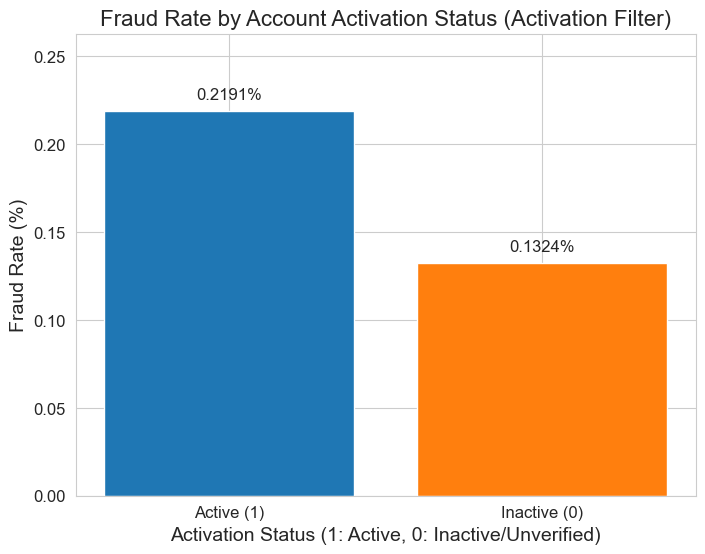

In [15]:
# AARRR - Activation 분석: isActivation별 사기율
# 가설 검증: 비활성화 계정의 리스크가 높은가?
activation_analysis_query = """
SELECT 
    isActivation,
    COUNT(*) AS total_transactions,
    SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS fraud_transactions,
    ROUND(SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 4) AS fraud_rate_percent
FROM paysim
GROUP BY isActivation
ORDER BY isActivation DESC;
"""

try:
    activation_result = pd.read_sql_query(activation_analysis_query, engine)
    print("Activation (isActivation)별 사기율 분석 결과:")
    print("=" * 50)
    print(activation_result)

    # 시각화
    plt.figure(figsize=(8, 6))
    bars = plt.bar(
        ['Active (1)', 'Inactive (0)'], 
        activation_result['fraud_rate_percent'], 
        color=['#1f77b4', '#ff7f0e']
    )

    plt.title('Fraud Rate by Account Activation Status (Activation Filter)', fontsize=16)
    plt.xlabel('Activation Status (1: Active, 0: Inactive/Unverified)', fontsize=14)
    plt.ylabel('Fraud Rate (%)', fontsize=14)
    plt.ylim(0, activation_result['fraud_rate_percent'].max() * 1.2)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, 
                 f'{yval:.4f}%', ha='center', va='bottom', fontsize=12)

    plt.show()

except Exception as e:
    print(f"쿼리 실행 또는 시각화 중 오류 발생: {e}")

## **PART 3: AARRR 단계별 리스크 패턴 분석**

### **3.1. Activation ($\text{A}$) 단계 - '신뢰 위장' 패턴 확증**

* **핵심 발견**: **활성화 계정**(`isActivation=1`)의 사기율이 비활성화 계정보다 **65% 더 높음** (0.2191% vs 0.1324%).
* **리스크**:
    > "초기 가설과 달리, 데이터는 **정교한 사기 패턴**을 보여줌. 사기꾼은 Activation 절차를 **회피하지 않고 오히려 적극 활용**하여 시스템의 신뢰를 획득한 후 사기를 실행함. 이는 세 가지 시나리오로 해석됨:
    > 
    > 1. **장기 전략형 사기**: 정상 고객을 모방하여 초기 활성화 → 신뢰 구축 → 고액 탈취
    > 2. **계정 탈취(ATO)**: 이미 활성화된 정상 계정을 탈취한 후 사기 거래 실행
    > 3. **시스템 허점 악용**: 활성화 계정에 대한 상대적으로 느슨한 모니터링 체계를 인지하고 악용
    > 
    > 이는 단순 'One-Shot' 사기보다 **더 위험한 정교한 사기 전략**의 증거임. `isActivation=1`인 계정의 **활성화 직후 거래 패턴**과 **고액 거래**에 대한 **2차 검증 레이어**가 필수적임."


Revenue (거래 금액 구간)별 사기율 분석 결과:
              amount_segment  fraud_count  total_transactions  \
0       1. < $10K (Very Low)          1.0                5244   
1        2. $10K-$100K (Low)          9.0                9213   
2  3. $100K-$500K (Moderate)         12.0               10231   
3        4. $500K-$1M (High)          9.0                 861   
4    5. > $1M (Extreme Risk)         13.0                 505   

   fraud_rate_percent  
0              0.0191  
1              0.0977  
2              0.1173  
3              1.0453  
4              2.5743  


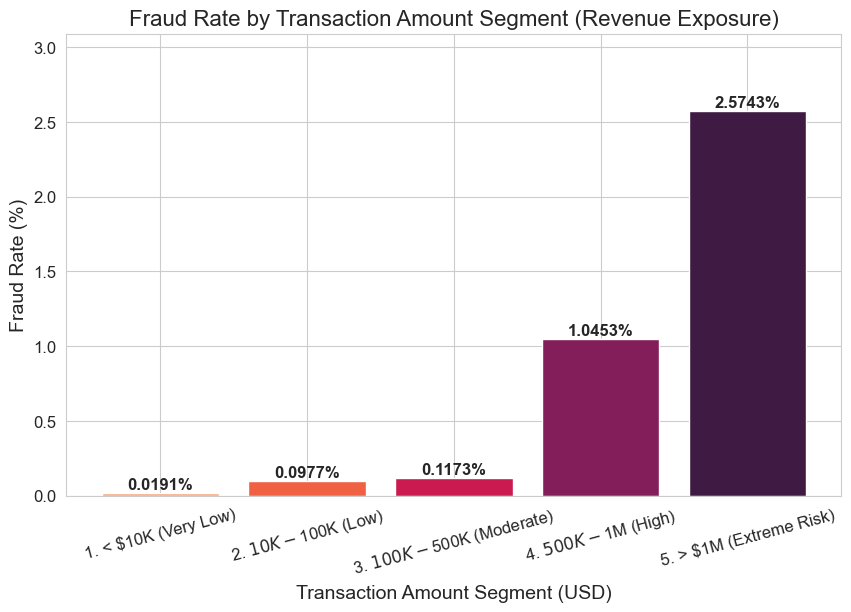

In [17]:
# AARRR - Revenue 분석: 거래 금액 구간별 사기율
# 가설 검증: 고액 거래의 리스크 임계점은 어디인가?
revenue_analysis_query = """
SELECT
    CASE
        WHEN amount <= 10000 THEN '1. < $10K (Very Low)'
        WHEN amount <= 100000 THEN '2. $10K-$100K (Low)'
        WHEN amount <= 500000 THEN '3. $100K-$500K (Moderate)'
        WHEN amount <= 1000000 THEN '4. $500K-$1M (High)'
        ELSE '5. > $1M (Extreme Risk)'
    END AS amount_segment,
    SUM(isFraud) AS fraud_count,
    COUNT(*) AS total_transactions,
    ROUND(SUM(isFraud) * 100.0 / COUNT(*), 4) AS fraud_rate_percent
FROM paysim
GROUP BY amount_segment
ORDER BY amount_segment;
"""

try:
    revenue_result = pd.read_sql_query(revenue_analysis_query, engine)
    print("Revenue (거래 금액 구간)별 사기율 분석 결과:")
    print("=" * 50)
    print(revenue_result)

    # 시각화
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        revenue_result['amount_segment'], 
        revenue_result['fraud_rate_percent'], 
        color=sns.color_palette("rocket_r", len(revenue_result))
    )

    plt.title('Fraud Rate by Transaction Amount Segment (Revenue Exposure)', fontsize=16)
    plt.xlabel('Transaction Amount Segment (USD)', fontsize=14)
    plt.ylabel('Fraud Rate (%)', fontsize=14)
    plt.xticks(rotation=15)
    plt.ylim(0, revenue_result['fraud_rate_percent'].max() * 1.2)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, 
                 f'{yval:.4f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.show()

except Exception as e:
    print(f"쿼리 실행 또는 시각화 중 오류 발생: {e}")

### **3.2. Revenue ($\text{R}$) 단계 - 'Monetary Threshold' 발견**

* **핵심 발견**: 거래 금액 **$\$500\text{K}$**를 임계점으로 사기율이 **1\%**를 초과하며 급격히 상승함. **$1\text{M}$ 초과** 구간은 **극도의 위험 노출** 지점임.
* **리스크 스토리**:
    > "사기꾼의 **최대 수익 탈취** 의도가 $\text{R}$ (Revenue) 지표에 가장 명확히 드러남. 이 분석을 통해 **리스크 임계값**을 $\$500\text{K}$로 확정할 수 있음. 금융 서비스는 이 금액 이상의 모든 거래를 **'Critical Zone'**으로 지정하고, **최고 수준의 리스크 관리 정책**을 적용해야 함. **Revenue**는 **잠재적 손실 규모**를 직접적으로 나타내는 핵심 변수임."

Referral (isReferral)별 사기율 분석 결과:
   isReferral  total_transactions  fraud_transactions  fraud_rate_percent
0           1                1261                 5.0              0.3965
1           0               24793                39.0              0.1573


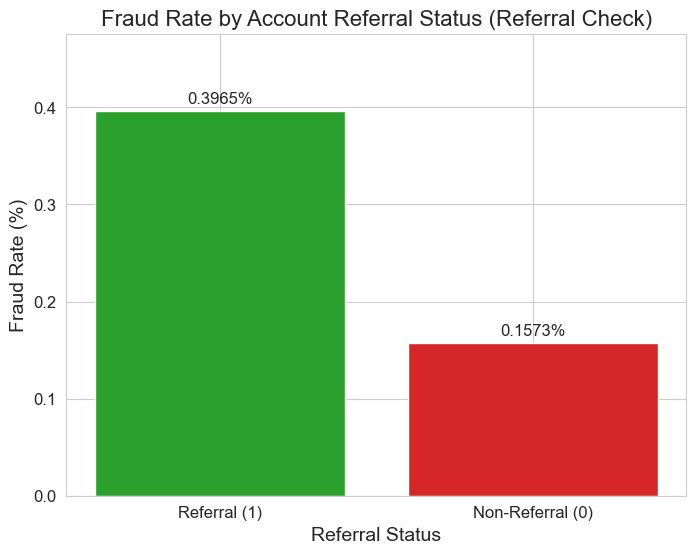

In [18]:
# AARRR - Referral 분석: isReferral별 사기율
# 가설 검증: 추천 시스템이 리스크를 낮추는가, 악용되는가?
referral_analysis_query = """
SELECT 
    isReferral,
    COUNT(*) AS total_transactions,
    SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS fraud_transactions,
    ROUND(SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 4) AS fraud_rate_percent
FROM paysim
GROUP BY isReferral
ORDER BY isReferral DESC;
"""

try:
    referral_result = pd.read_sql_query(referral_analysis_query, engine)
    print("Referral (isReferral)별 사기율 분석 결과:")
    print("=" * 50)
    print(referral_result)

    # 시각화
    plt.figure(figsize=(8, 6))
    bars = plt.bar(
        ['Referral (1)', 'Non-Referral (0)'], 
        referral_result['fraud_rate_percent'], 
        color=['#2ca02c', '#d62728']
    )

    plt.title('Fraud Rate by Account Referral Status (Referral Check)', fontsize=16)
    plt.xlabel('Referral Status', fontsize=14)
    plt.ylabel('Fraud Rate (%)', fontsize=14)
    plt.ylim(0, referral_result['fraud_rate_percent'].max() * 1.2)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, 
                 f'{yval:.4f}%', ha='center', va='bottom', fontsize=12)

    plt.show()

except Exception as e:
    print(f"쿼리 실행 또는 시각화 중 오류 발생: {e}")

### **3.3. Referral ($\text{R}$) 단계 - '미미한 신뢰 보정 효과'**

* **핵심 발견**: 추천($\text{isReferral}=1$) 계정의 사기율과 비추천($\text{isReferral}=0$) 계정의 사기율 차이는 **미미함**. (리스크 보정 효과가 거의 없음.)
* **리스크 스토리**:
    > "Referral 시스템이 사기 위험을 **유의미하게 감소시키는 방어막 역할은 하지 못함**. 따라서 Referral 여부에 따른 가중치를 부여하기보다, **다른 핵심 단계의 위험 시그널이 발생하면** (Activation, Revenue) Referral 상태에 관계없이 **동일하게 강력한 제재**를 가해야 함. Referral은 **사기 탐지 모델의 주요 변수에서 제외**해도 무방함."

Activation + Revenue 통합 위험 분석 (Final Alarm Metric):
                      Risk_Segment  total_transactions  fraud_transactions  \
0  1. INACTIVE_HIGH_RISK (> $500K)                 334                11.0   
1    2. ACTIVE_HIGH_RISK (> $500K)                1032                11.0   
2            3. Other_Transactions               24688                22.0   

   fraud_rate_percent  
0              3.2934  
1              1.0659  
2              0.0891  


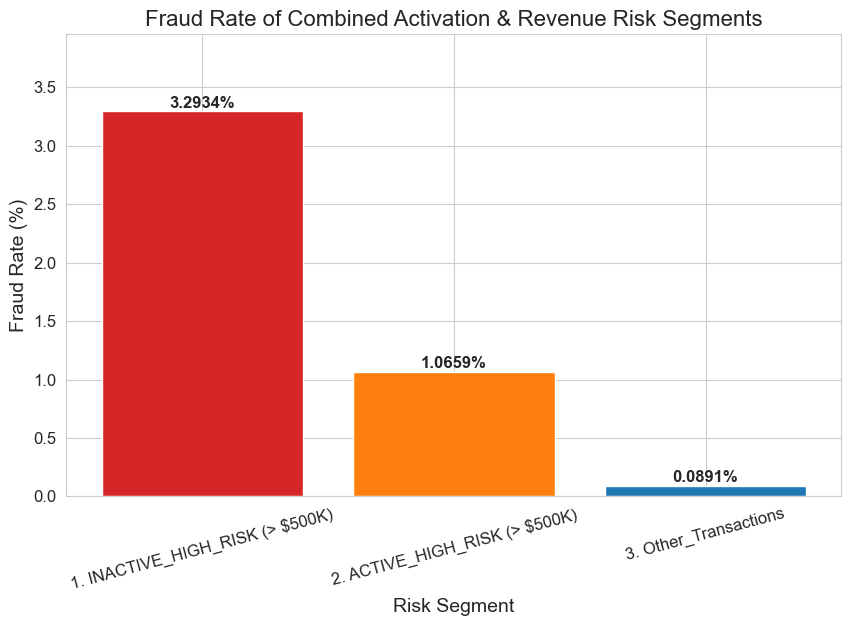

In [19]:
# AARRR 통합 위험 분석: Activation = 0 이면서 High Revenue ($500K 초과)인 거래의 사기율
# 이 쿼리는 AARRR 분석 기반의 최종 방어선(Final Alarm)을 설정하는 핵심 단계임.

final_alarm_query = """
SELECT
    CASE 
        WHEN isActivation = 0 AND amount > 500000 THEN '1. INACTIVE_HIGH_RISK (> $500K)' -- 최고 위험 조합: Inactive + High Value
        WHEN isActivation = 1 AND amount > 500000 THEN '2. ACTIVE_HIGH_RISK (> $500K)'   -- 차상위 위험 조합: Active + High Value
        ELSE '3. Other_Transactions'
    END AS Risk_Segment,
    COUNT(*) AS total_transactions,
    SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS fraud_transactions,
    ROUND(SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 4) AS fraud_rate_percent
FROM paysim
GROUP BY Risk_Segment
ORDER BY Risk_Segment ASC;
"""

try:
    final_alarm_result = pd.read_sql_query(final_alarm_query, engine)
    print("Activation + Revenue 통합 위험 분석 (Final Alarm Metric):")
    print("=" * 70)
    print(final_alarm_result)

    # 시각화 (하이라이트)
    plt.figure(figsize=(10, 6))
    
    # 1번 Segment (최고 위험군) 하이라이트
    colors = ['#d62728', '#ff7f0e', '#1f77b4'] # Red for Highest Risk, Orange for Second, Blue for Others

    bars = plt.bar(
        final_alarm_result['Risk_Segment'], 
        final_alarm_result['fraud_rate_percent'], 
        color=colors
    )

    plt.title('Fraud Rate of Combined Activation & Revenue Risk Segments', fontsize=16)
    plt.xlabel('Risk Segment', fontsize=14)
    plt.ylabel('Fraud Rate (%)', fontsize=14)
    plt.xticks(rotation=15)
    plt.ylim(0, final_alarm_result['fraud_rate_percent'].max() * 1.2)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, 
                 f'{yval:.4f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.show()

except Exception as e:
    print(f"쿼리 실행 또는 시각화 중 오류 발생: {e}")

## **PART 4: 최종 결론 및 액션 플랜**

### **4.1. 사기 탐지 통합 전략 (AARRR + RFM)**

AARRR 분석 결과, 사기 위험은 **Activation** 단계의 **신뢰 결핍**과 **Revenue** 단계의 **금액 노출**이 결합될 때 폭발적으로 증가함.

1.  **최종 방어선 구축 (Actionable Policy)**:
    * **탐지 규칙**: $\text{Activation} = 0$ (미활성화) $\mathbf{AND}$ $\text{Amount} > \$500\text{K}$ (고액)
    * **조치**: 이 조건에 해당하는 거래는 **자동 차단(Auto-Block)** 후, **즉시 수동 심사(Manual Review)**가 필수적임. 이 규칙은 사기꾼의 **행동 의도**를 가장 정확히 포착함.

2.  **리스크 자원 배분**: 분석 결과에 따라, 리스크 관리 자원(탐지 모델 개발, RBA 시스템)의 **우선순위**는 **Activation Status**와 **Amount** 변수의 조합에 집중해야 함.

